In [20]:
#cruzando pontos de queimadas com TIs e UCs

import zipfile
import os
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


bd_2024 = pd.read_csv('focos_qmd_inpe_2024-01-01_2024-09-10_13.231475.csv')
bd_2024['geometry'] = bd_2024.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
focos_2024 = gpd.GeoDataFrame(bd_2024, geometry='geometry')
focos_2024.set_crs(epsg=4326, inplace=True)

from shapely import wkt
amazonia = pd.read_csv('focos_amazona_2003_2023.csv')
amazonia['centroide'] = amazonia['centroide'].apply(wkt.loads)

focos_serie = gpd.GeoDataFrame(amazonia, geometry='centroide')
focos_serie.set_crs(epsg=4326, inplace=True)
focos_serie.rename(columns={'data_hora': 'DataHora'}, inplace=True)


zip_file_path_TI = 'H:\Infoamazonia\shapes\indigenous_area_legal_amazon.zip'
extracted_folder_TI = 'H:\Infoamazonia\shapes\indigeneous_area_legal_amazon'

with zipfile.ZipFile(zip_file_path_TI, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_TI)

shapefile_path_TI = os.path.join(extracted_folder_TI, 'H:\Infoamazonia\shapes\indigeneous_area_legal_amazon\indigenous_area_legal_amazon.shp')
areas_gdf_TI = gpd.read_file(shapefile_path_TI)
focos_TI = gpd.overlay(focos_2024, areas_gdf_TI, how='intersection')
print(focos_TI)

<>:27: SyntaxWarning: invalid escape sequence '\I'
<>:28: SyntaxWarning: invalid escape sequence '\I'
<>:33: SyntaxWarning: invalid escape sequence '\I'
<>:27: SyntaxWarning: invalid escape sequence '\I'
<>:28: SyntaxWarning: invalid escape sequence '\I'
<>:33: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_20212\2171568683.py:27: SyntaxWarning: invalid escape sequence '\I'
  zip_file_path_TI = 'H:\Infoamazonia\shapes\indigenous_area_legal_amazon.zip'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_20212\2171568683.py:28: SyntaxWarning: invalid escape sequence '\I'
  extracted_folder_TI = 'H:\Infoamazonia\shapes\indigeneous_area_legal_amazon'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_20212\2171568683.py:33: SyntaxWarning: invalid escape sequence '\I'
  shapefile_path_TI = os.path.join(extracted_folder_TI, 'H:\Infoamazonia\shapes\indigeneous_area_legal_amazon\indigenous_area_legal_amazon.shp')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_202

                 DataHora  Satelite    Pais    Estado  \
0     2024/01/04 18:34:00  AQUA_M-T  Brasil   RORAIMA   
1     2024/01/04 18:34:00  AQUA_M-T  Brasil   RORAIMA   
2     2024/01/04 18:32:00  AQUA_M-T  Brasil  AMAZONAS   
3     2024/01/04 18:32:00  AQUA_M-T  Brasil  AMAZONAS   
4     2024/01/04 18:32:00  AQUA_M-T  Brasil  AMAZONAS   
...                   ...       ...     ...       ...   
9330  2024/09/09 19:38:00  AQUA_M-T  Brasil      ACRE   
9331  2024/09/10 17:05:00  AQUA_M-T  Brasil  MARANHÃO   
9332  2024/09/10 17:05:00  AQUA_M-T  Brasil      PARÁ   
9333  2024/09/10 17:05:00  AQUA_M-T  Brasil      PARÁ   
9334  2024/09/10 17:05:00  AQUA_M-T  Brasil      PARÁ   

                     Municipio     Bioma  DiaSemChuva  Precipitacao  \
0                     UIRAMUTÃ  Amazônia          9.0           0.0   
1                     UIRAMUTÃ  Amazônia          9.0           0.0   
2     SÃO GABRIEL DA CACHOEIRA  Amazônia          4.0           0.0   
3     SÃO GABRIEL DA CACHOEIRA 

In [2]:
# Calculando o total de focos por terra indígena a partir de 1º de julho
#este recorte temporal concentra o escopo de apuração na atual temporada de queimadas


focos_TI['DataHora'] = pd.to_datetime(focos_TI['DataHora'], format='%Y/%m/%d %H:%M:%S')

terrai_ranking = focos_TI['terrai_nom'].value_counts().reset_index()
terrai_ranking.columns = ['terrai_nom', 'total_focos']

# Filtrando os focos a partir de 1º de julho
julho = pd.Timestamp('2024-07-01')

focos_TI_july = focos_TI[focos_TI['DataHora'] >= julho]
ranking_july = focos_TI_july['terrai_nom'].value_counts().reset_index()
ranking_july.columns = ['terrai_nom', 'focos_jul/set']
terrai_ranking = terrai_ranking.merge(ranking_july, on='terrai_nom', how='left').fillna(0)

terrai_ranking.head(15)

,terrai_nom,total_focos,focos_jul/set
0,Kayapó,2218,2213.0
1,Capoto/Jarina,609,606.0
2,Munduruku,498,496.0
3,Yanomami,414,2.0
4,Sararé,342,342.0
5,Xikrin do Rio Catete,329,326.0
6,Raposa Serra do Sol,289,4.0
7,Nambikwara,271,259.0
8,Menkragnoti,267,267.0
9,Parque do Aripuanã,247,245.0


In [3]:
focos_por_dia = focos_TI_july.groupby(focos_TI_july['DataHora'].dt.date).size()
media_focos_por_dia = focos_por_dia.mean()
media_focos_por_dia

113.38888888888889

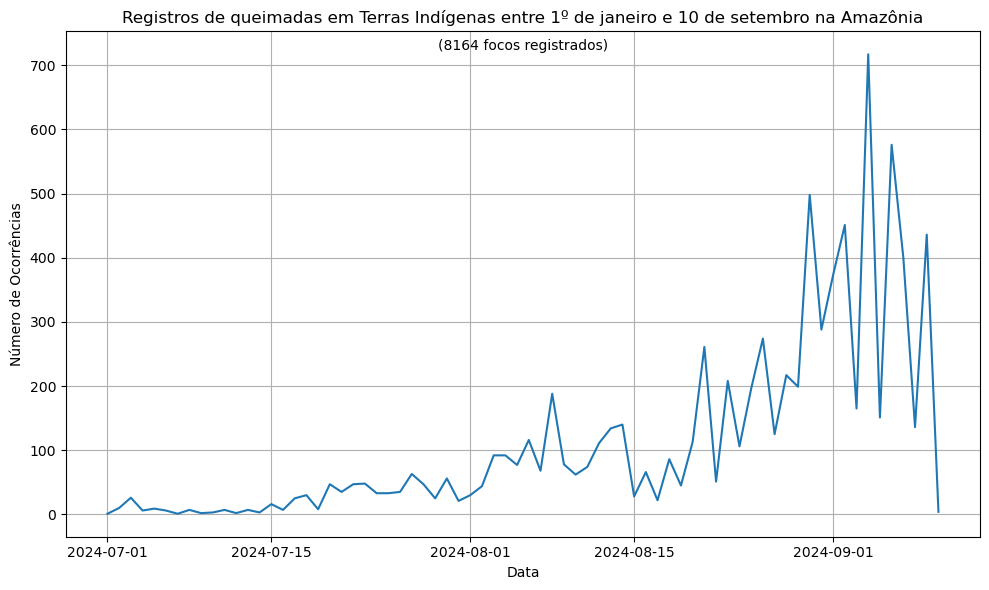

In [6]:
focos_por_dia = focos_TI_july.groupby(focos_TI_july['DataHora'].dt.date).agg(quantidade_focos=('FRP', 'count')).reset_index()

plt.figure(figsize=(10, 6))

plt.plot(focos_por_dia['DataHora'], focos_por_dia['quantidade_focos'], marker='')

focos_TIs_periodo = focos_por_dia['quantidade_focos'].sum()

plt.title('Registros de queimadas em Terras Indígenas entre 1º de janeiro e 10 de setembro na Amazônia')
plt.text(0.5, 0.97, f'({focos_TIs_periodo} focos registrados)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

plt.xlabel('Data')
plt.ylabel('Número de Ocorrências')

plt.grid(True)
plt.tight_layout()

plt.show()


In [7]:
#Calculando a média de focos por dia nos territórios
terrai_ranking = focos_TI_july['terrai_nom'].value_counts().reset_index()
terrai_ranking.columns = ['terrai_nom', 'focos jul/set']
focos_por_dia_territorio = focos_TI_july.groupby([focos_TI_july['DataHora'].dt.date, 'terrai_nom']).size().unstack(fill_value=0)
media_focos_por_dia_territorio = focos_por_dia_territorio.mean().reset_index()
media_focos_por_dia_territorio.columns = ['terrai_nom', 'media_focos_por_dia']
terrai_ranking = pd.merge(terrai_ranking, media_focos_por_dia_territorio, on='terrai_nom')
terrai_ranking.head(15)


,terrai_nom,focos jul/set,media_focos_por_dia
0,Kayapó,2213,30.736111
1,Capoto/Jarina,606,8.416667
2,Munduruku,496,6.888889
3,Sararé,342,4.750000
4,Xikrin do Rio Catete,326,4.527778
5,Menkragnoti,267,3.708333
6,Nambikwara,259,3.597222
7,Apyterewa,247,3.430556
8,Parque do Aripuanã,245,3.402778
9,Vale do Guaporé,199,2.763889


<Figure size 1000x600 with 0 Axes>

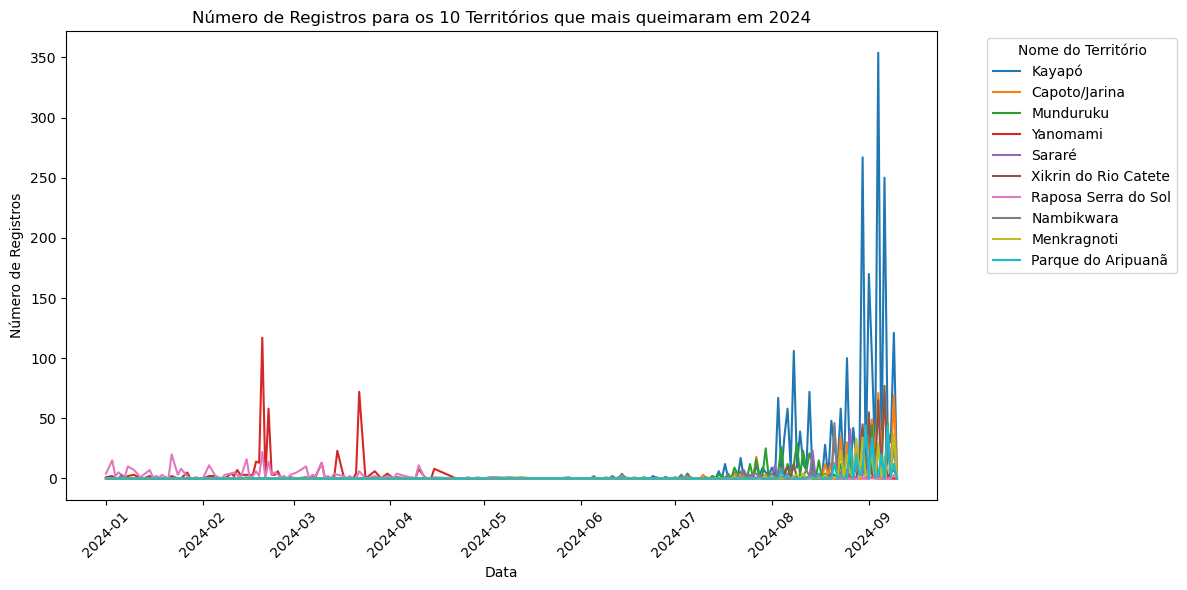

In [9]:
#Aqui são os dados desde o início do ano de

focos_TI['DataHora'] = pd.to_datetime(focos_TI['DataHora'], format='%Y/%m/%d %H:%M:%S')
time_territory_counts = focos_TI.groupby([focos_TI['DataHora'].dt.date, 'terrai_nom']).size().unstack(fill_value=0)

top_5_territories = focos_TI['terrai_nom'].value_counts().head(10).index
time_territory_counts_top_5 = time_territory_counts[top_5_territories]
plt.figure(figsize=(10, 6))
time_territory_counts_top_5.plot(kind='line', figsize=(12, 6))
plt.title('Número de Registros para os 10 Territórios que mais queimaram em 2024')
plt.xlabel('Data')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.legend(title='Nome do Território', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


<Figure size 1000x600 with 0 Axes>

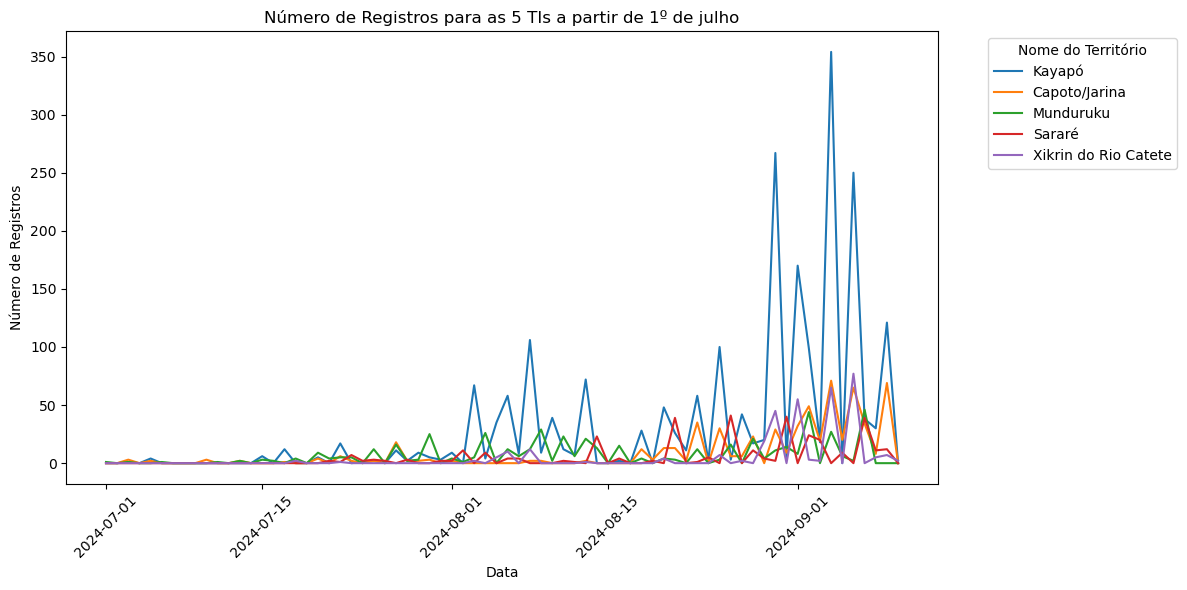

In [10]:
#entre 1 de julho e 10 de setembro de 2024
#  
julho = pd.Timestamp('2024-07-01')
focos_TI_july = focos_TI[focos_TI['DataHora'] >= julho]
time_territory_counts = focos_TI_july.groupby([focos_TI_july['DataHora'].dt.date, 'terrai_nom']).size().unstack(fill_value=0)
top_5_territories = focos_TI_july['terrai_nom'].value_counts().head(5).index
time_territory_counts_top_10 = time_territory_counts[top_5_territories]
plt.figure(figsize=(10, 6))
time_territory_counts_top_10.plot(kind='line', figsize=(12, 6))
plt.title('Número de Registros para as 5 TIs a partir de 1º de julho')
plt.xlabel('Data')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.legend(title='Nome do Território', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20212\4069381474.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


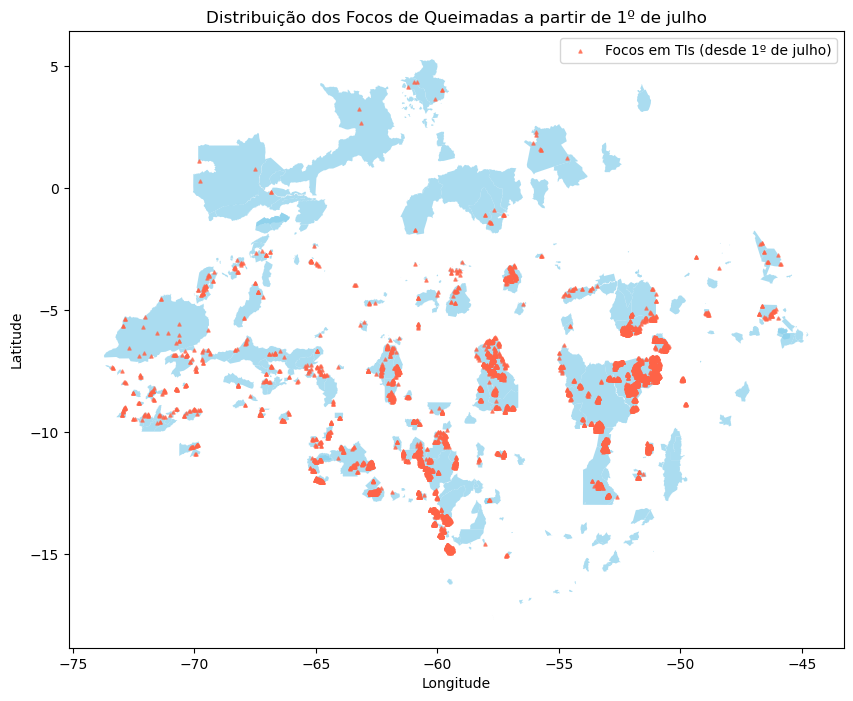

In [11]:
julho = pd.Timestamp('2024-07-01')
focos_2024['DataHora'] = pd.to_datetime(focos_2024['DataHora'], format='%Y/%m/%d %H:%M:%S')
focos_UC['DataHora'] = pd.to_datetime(focos_UC['DataHora'], format='%Y/%m/%d %H:%M:%S')
focos_TI['DataHora'] = pd.to_datetime(focos_TI['DataHora'], format='%Y/%m/%d %H:%M:%S')
geo_df_july = focos_2024[focos_2024['DataHora'] >= julho]
focos_TI_july = focos_TI[focos_TI['DataHora'] >= julho]
fig, ax = plt.subplots(figsize=(10, 10))
areas_gdf_TI.plot(ax=ax, marker='^', color='#87CEEB', markersize=5, label='Terras Indígenas', alpha=0.7)  # Rosa claro
#geo_df_july.plot(ax=ax, marker='o', color='#87CEEB', markersize=5, label='Focos gerais (desde 1º de julho)', alpha=0.7)  # Azul suave
focos_TI_july.plot(ax=ax, marker='^', color='#FF6347', markersize=5, label='Focos em TIs (desde 1º de julho)', alpha=0.7)  # Vermelho suave
plt.title('Distribuição dos Focos de Queimadas a partir de 1º de julho')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')
plt.show()


In [17]:
zip_file_path_TI = 'H:/Infoamazonia/shapes/indigenous_area_legal_amazon.zip'
extracted_folder_TI = 'H:/Infoamazonia/shapes/indigenous_area_legal_amazon'

with zipfile.ZipFile(zip_file_path_TI, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_TI)

shapefile_path_TI = os.path.join(extracted_folder_TI, 'indigenous_area_legal_amazon.shp')
areas_gdf_TI = gpd.read_file(shapefile_path_TI)

areas_gdf_TI = areas_gdf_TI.to_crs(focos_serie.crs)

hist_TI = gpd.overlay(focos_serie, areas_gdf_TI, how='intersection')

hist_TI['DataHora'] = pd.to_datetime(hist_TI['DataHora'])

start_date = '07-01'
end_date = '09-10'
mask = (hist_TI['DataHora'].dt.month >= 7) & (hist_TI['DataHora'].dt.month <= 9) & \
       ((hist_TI['DataHora'].dt.month != 9) | (hist_TI['DataHora'].dt.day <= 10))
hist_TI_filtered = hist_TI[mask]

df_focos_TI_ano = hist_TI_filtered.groupby([hist_TI_filtered['DataHora'].dt.year, 'terrai_nom']).agg(quantidade_focos=('id', 'count')).reset_index()

focos_TI['DataHora'] = pd.to_datetime(focos_TI['DataHora'])
mask_b = (focos_TI['DataHora'].dt.month >= 7) & (focos_TI['DataHora'].dt.month <= 9) & \
         ((focos_TI['DataHora'].dt.month != 9) | (focos_TI['DataHora'].dt.day <= 10))
hist_TI_filtered_b = focos_TI[mask_b]

df_focos_ano_c = hist_TI_filtered_b.groupby([hist_TI_filtered_b['DataHora'].dt.year, 'terrai_nom']).agg(quantidade_focos=('id', 'count')).reset_index()

df_concatenado_TI = pd.concat([df_focos_TI_ano, df_focos_ano_c], ignore_index=True)

df_concatenado_TI


,DataHora,terrai_nom,quantidade_focos
0,2003,Alto Rio Guamá,6
1,2003,Alto Rio Purus,18
2,2003,Alto Sepatini,1
3,2003,Alto Turiaçu,2
4,2003,Andirá-Marau,23
...,...,...,...
3237,2024,Zoró,70
3238,2024,Zuruahã,1
3239,2024,Água Preta/Inari,3
3240,2024,Évare I,21


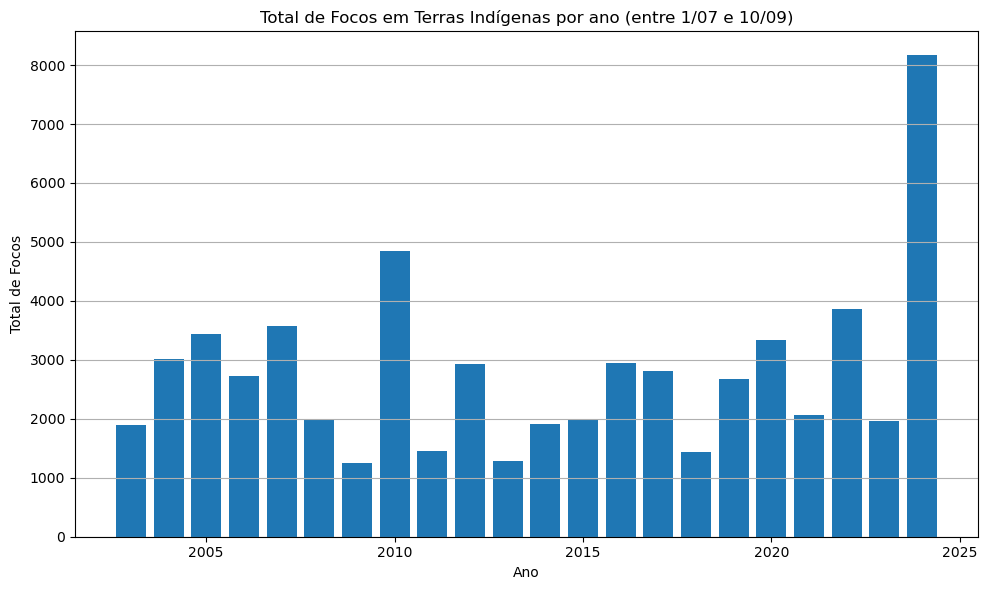

In [18]:
tis_anos = df_concatenado_TI.groupby('DataHora')['quantidade_focos'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(tis_anos['DataHora'], tis_anos['quantidade_focos'])
plt.title('Total de Focos em Terras Indígenas por ano (entre 1/07 e 10/09)')
plt.xlabel('Ano')
plt.ylabel('Total de Focos')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [19]:
tis_anos

,DataHora,quantidade_focos
0,2003,1888
1,2004,3015
2,2005,3441
3,2006,2731
4,2007,3580
5,2008,1973
6,2009,1243
7,2010,4846
8,2011,1457
9,2012,2926


c:\Users\Usuario\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


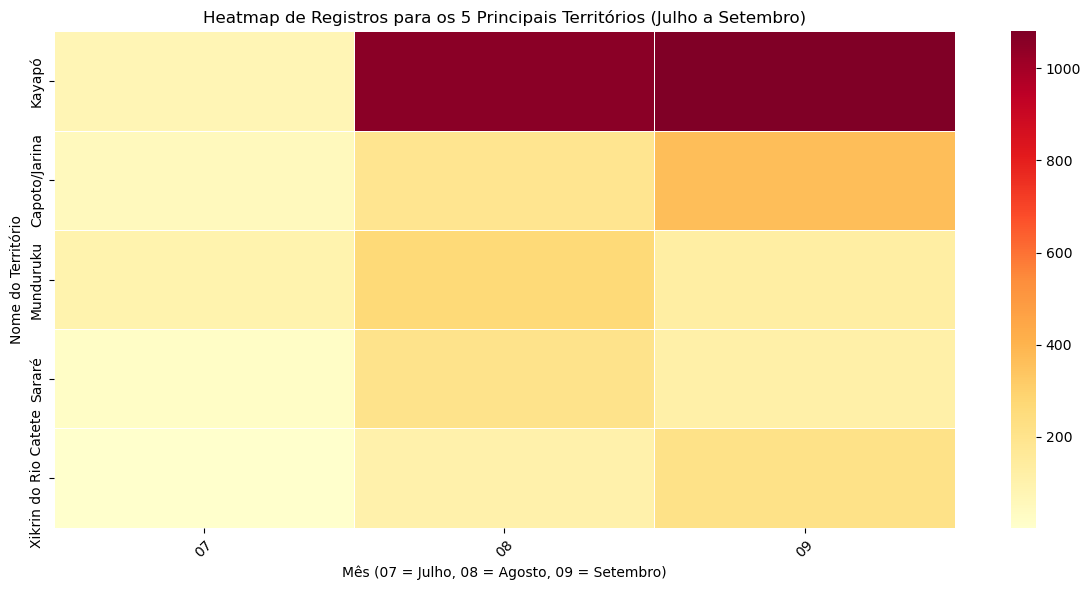

In [26]:
focos_TI['DataHora'] = pd.to_datetime(focos_TI['DataHora'])

julho = pd.Timestamp('2024-07-01')
focos_TI_july = focos_TI[focos_TI['DataHora'] >= julho]

focos_TI_july['Month'] = focos_TI_july['DataHora'].dt.strftime('%m')

ti_counts_month = focos_TI_july.groupby(['Month', 'terrai_nom']).size().unstack(fill_value=0)

top_5_territories = focos_TI_july['terrai_nom'].value_counts().head(5).index
ti_counts_top_5 = ti_counts_month[top_5_territories]

plt.figure(figsize=(12, 6))
sns.heatmap(ti_counts_top_5.T, cmap='YlOrRd', linewidths=0.5, linecolor='white')

plt.title('Heatmap de Registros para os 5 Principais Territórios (Julho a Setembro)')
plt.xlabel('Mês (07 = Julho, 08 = Agosto, 09 = Setembro)')
plt.ylabel('Nome do Território')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar o gráfico
plt.show()
